# Inference on cGAN Generated Plant Disease Images

## Import Libraries

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Processing 

In [17]:
# Dataset Paths
data_dir = "/kaggle/input/generated-plant-disease-dataset/generated-plant-disease-data"
image_size = 224

# Data Preprocessing
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_100_epoch_dataset = test_datagen.flow_from_directory(
    f'{data_dir}/100epochs',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)

test_200_epoch_dataset = test_datagen.flow_from_directory(
    f'{data_dir}/200epochs',
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='sparse'
)

Found 15 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


## ViT Model

In [16]:
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, mlp_dim, dropout, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout_rate = dropout

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(d_model),
            layers.Dropout(dropout),
        ])

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.norm1(inputs + attn_output)
        mlp_output = self.mlp(out1)
        return self.norm2(out1 + mlp_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout_rate,
        })
        return config

class VisionTransformer(Model):
    def __init__(self, num_classes, image_size=224, patch_size=16, num_patches=196, 
                 d_model=64, num_heads=4, mlp_dim=128, num_layers=6, dropout=0.1, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.patch_dim = patch_size * patch_size * 3
        self.d_model = d_model
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.patch_projection = layers.Dense(d_model)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=d_model)
        self.transformer_blocks = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]

        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.GlobalAveragePooling1D(),
            layers.Dense(mlp_dim, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(num_classes, activation='softmax')
        ])

    def extract_patches(self, images, p_size):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, p_size, p_size, 1],
            strides=[1, p_size, p_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

    def call(self, inputs):
        p_size = int((self.patch_dim / 3)**0.5)
        x = self.extract_patches(inputs, p_size)
        x = self.patch_projection(x)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        x = x + self.position_embedding(positions)

        for block in self.transformer_blocks:
            x = block(x)

        return self.mlp_head(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "image_size": self.image_size,
            "patch_size": self.patch_size,
            "num_patches": self.num_patches,
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "num_layers": self.num_layers,
            "dropout": self.dropout,
        })
        return config

## Load Pre-trained ViT Model Weights

In [18]:
# Instantiate the model with the original training parameters
vit_model = VisionTransformer(
    num_classes=3,
    image_size=224,
    patch_size=16,
    num_patches=(224 // 16)**2,
    d_model=64,
    num_heads=4,
    mlp_dim=128,
    num_layers=6,
    dropout=0.1
)

# Build the model by calling it once
vit_model(tf.random.normal([1, 224, 224, 3]))

# Load weights from the .h5 file
vit_model.load_weights("/kaggle/input/vit-plant-disease-model/tensorflow2/default/1/vit_plant_disease_model.h5")

# Compile the model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)



## ViT Evaluation

In [19]:
# Evaluate and predict
test_100_loss, test_100_acc = vit_model.evaluate(test_100_epoch_dataset, verbose=1)
test_200_loss, test_200_acc = vit_model.evaluate(test_200_epoch_dataset, verbose=1)

print("Test (100 epochs) - Loss:", test_100_loss, "Accuracy:", test_100_acc)
print("Test (200 epochs) - Loss:", test_200_loss, "Accuracy:", test_200_acc)

y_pred_100 = np.argmax(vit_model.predict(test_100_epoch_dataset), axis=1)
y_pred_200 = np.argmax(vit_model.predict(test_200_epoch_dataset), axis=1)

y_true_100 = test_100_epoch_dataset.classes
y_true_200 = test_200_epoch_dataset.classes

class_labels = list(test_100_epoch_dataset.class_indices.keys())

# Classification report
print("Classification Report (100 epochs):")
print(classification_report(y_true_100, y_pred_100, target_names=class_labels))

print("Classification Report (200 epochs):")
print(classification_report(y_true_200, y_pred_200, target_names=class_labels))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8000 - loss: 0.8698
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step - accuracy: 0.7333 - loss: 0.6414
Test (100 epochs) - Loss: 0.8697978258132935 Accuracy: 0.800000011920929
Test (200 epochs) - Loss: 0.6414495706558228 Accuracy: 0.7333333492279053
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report (100 epochs):
              precision    recall  f1-score   support

     Healthy       0.17      0.20      0.18         5
     Powdery       0.43      0.60      0.50         5
        Rust       0.00      0.00      0.00         5

    accuracy                           0.27        15
   macro avg       0.20      0.27      0.23        15
weighted avg       0.20      0.27      0.23        15

Classification Report (200 epochs):
              precision    recall  f1-score   support

     Healthy       0.10      0.10      0.10        10
     Powdery       0.29      0.20      0.24        10
        Rust       0.3

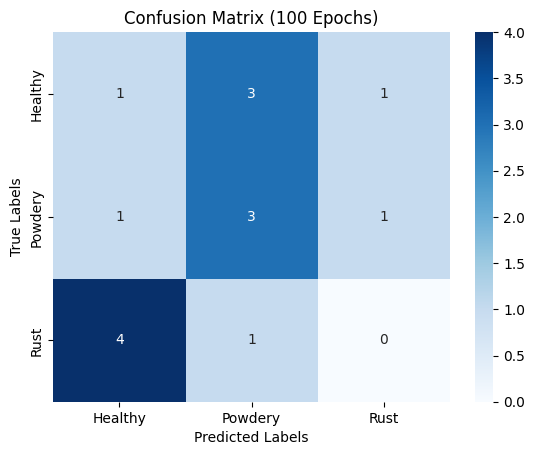

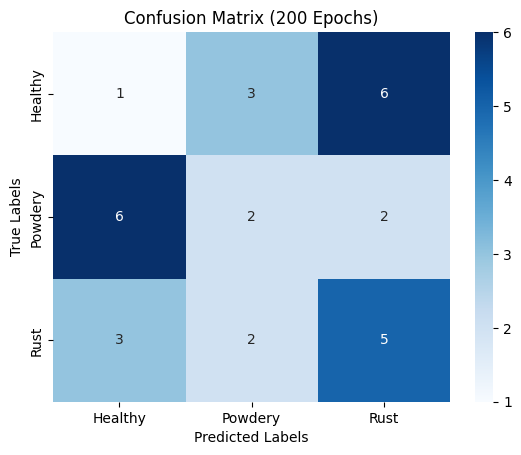

In [20]:
# Confusion matrix for 100 epochs
cm_100 = confusion_matrix(test_100_epoch_dataset.classes, y_pred_100)
sns.heatmap(cm_100, annot=True, fmt='d', cmap='Blues', xticklabels=test_100_epoch_dataset.class_indices.keys(), yticklabels=test_100_epoch_dataset.class_indices.keys())
plt.title('Confusion Matrix (100 Epochs)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion matrix for 200 epochs
cm_200 = confusion_matrix(test_200_epoch_dataset.classes, y_pred_200)
sns.heatmap(cm_200, annot=True, fmt='d', cmap='Blues', xticklabels=test_200_epoch_dataset.class_indices.keys(), yticklabels=test_200_epoch_dataset.class_indices.keys())
plt.title('Confusion Matrix (200 Epochs)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## ResNet50 Model

In [28]:
# Residual Block Definition
class ResidualBlock(Model):
    def __init__(self, filters, kernel_size, strides=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.downsample = downsample

        # Main path
        self.conv1 = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')
        self.bn2 = layers.BatchNormalization()

        # Shortcut path
        if self.downsample:
            self.shortcut = tf.keras.Sequential([
                layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal'),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

    def call(self, inputs):
        shortcut = self.shortcut(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        return self.relu(x + shortcut)


# ResNet50 Model Definition
class ResNet50(Model):
    def __init__(self, num_classes, trainable=True):
        super(ResNet50, self).__init__()

        self.conv1 = layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.maxpool = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')

        # Residual blocks
        self.layer1 = self._build_residual_layer(64, 3, strides=1)
        self.layer2 = self._build_residual_layer(128, 4, strides=2)
        self.layer3 = self._build_residual_layer(256, 6, strides=2)
        self.layer4 = self._build_residual_layer(512, 3, strides=2)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

        for layer in self.layers:
                layer.trainable = trainable 

    def _build_residual_layer(self, filters, blocks, strides):
        layers_list = [ResidualBlock(filters, kernel_size=3, strides=strides, downsample=True)]
        for _ in range(1, blocks):
            layers_list.append(ResidualBlock(filters, kernel_size=3))
        return tf.keras.Sequential(layers_list)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return self.fc(x)

## Load Pre-trained ResNet50 Model Weights

In [32]:
# Instantiate the ResNet50 model
num_classes = 3  # Must be the same as during training
resnet50_model = ResNet50(num_classes)

# VERY IMPORTANT: Build the model by calling it once with a dummy input
resnet50_model(tf.random.normal([1, 224, 224, 3]))

# Load the weights
resnet50_model.load_weights('/kaggle/input/resnet50-plant-disease-detection-model/tensorflow2/default/1/resnet50_plant_disease_model_from_scratch.h5')

# Compile the model
resnet50_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4667 - loss: 7.1706
Test (100 epochs) - Loss: 7.17057466506958 Accuracy: 0.46666666865348816


## Evaluation

In [33]:
resnet50_test_100_loss, resnet50_test_100_acc = resnet50_model.evaluate(test_100_epoch_dataset)
resnet50_test_200_loss, resnet50_test_200_acc = resnet50_model.evaluate(test_200_epoch_dataset)

print("Test ResNet50 (100 epochs) - Loss:", resnet50_test_100_loss, "Accuracy:", resnet50_test_100_acc)
print("Test ResNet50 (200 epochs) - Loss:", resnet50_test_200_loss, "Accuracy:", resnet50_test_200_acc)

resnet50_y_pred_100 = np.argmax(resnet50_model.predict(test_100_epoch_dataset), axis=1)
resnet50_y_pred_200 = np.argmax(resnet50_model.predict(test_200_epoch_dataset), axis=1)

resnet50_y_true_100 = test_100_epoch_dataset.classes
resnet50_y_true_200 = test_200_epoch_dataset.classes

class_labels = list(test_100_epoch_dataset.class_indices.keys())

# Classification report
print("ResNet50 Classification Report (100 epochs):")
print(classification_report(resnet50_y_true_100, resnet50_y_pred_100, target_names=class_labels))

print("ResNet50 Classification Report (200 epochs):")
print(classification_report(resnet50_y_true_200, resnet50_y_pred_200, target_names=class_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4667 - loss: 7.1706
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7000 - loss: 1.5736
Test ResNet50 (100 epochs) - Loss: 7.170573711395264 Accuracy: 0.46666666865348816
Test ResNet50 (200 epochs) - Loss: 1.573574423789978 Accuracy: 0.699999988079071
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
ResNet50 Classification Report (100 epochs):
              precision    recall  f1-score   support

     Healthy       0.33      0.80      0.47         5
     Powdery       0.00      0.00      0.00         5
        Rust       0.00      0.00      0.00         5

    accuracy                           0.27        15
   macro avg       0.11      0.27      0.16        15
weighted avg       0.11      0.27      0.16        15

ResNet50 Classification Report (200 epochs):
              precision    recall  f1-score   support

     Healthy       0.27      0.40      0.32        10
     Powdery       0.25      0.20      0.22 

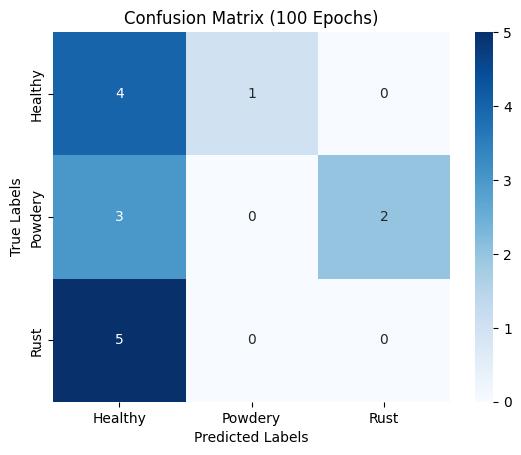

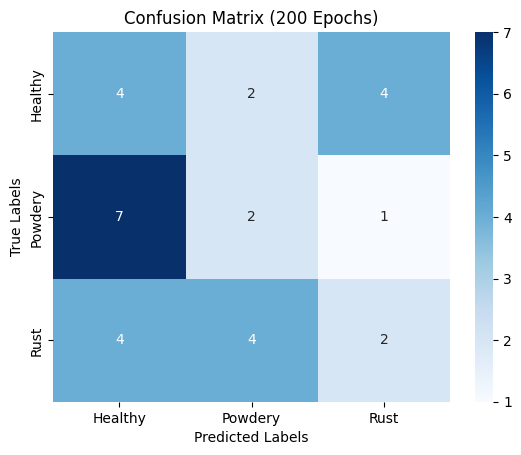

In [34]:
# Confusion matrix for 100 epochs
cm_100 = confusion_matrix(test_100_epoch_dataset.classes, resnet50_y_pred_100)
sns.heatmap(cm_100, annot=True, fmt='d', cmap='Blues', xticklabels=test_100_epoch_dataset.class_indices.keys(), yticklabels=test_100_epoch_dataset.class_indices.keys())
plt.title('Confusion Matrix (100 Epochs)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Confusion matrix for 200 epochs
cm_200 = confusion_matrix(test_200_epoch_dataset.classes, resnet50_y_pred_200)
sns.heatmap(cm_200, annot=True, fmt='d', cmap='Blues', xticklabels=test_200_epoch_dataset.class_indices.keys(), yticklabels=test_200_epoch_dataset.class_indices.keys())
plt.title('Confusion Matrix (200 Epochs)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()